## Import libraries and modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Workaround for https://github.com/tensorflow/tensorflow/issues/23999
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from tensorflow.keras.backend import set_session, image_data_format
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical

from time import time

## Configure tensorflow

In [2]:
np.random.seed(123)  # for reproducibility

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

## Load pre-shuffled MNIST data into train and test sets

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

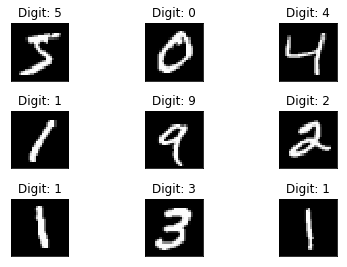

In [4]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

## Preprocess input data

In [5]:
if image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape=(1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape=(28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## Preprocess class labels

In [6]:
#set number of categories
num_category = 10
y_train = to_categorical(y_train, num_category)
y_test = to_categorical(y_test, num_category)

## Define model architecture

In [7]:
model = Sequential()
 
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compile model

In [8]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

## TensorBoard logging

In [9]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(time()))
# while training use this command to visualize progress:
# tensorboard --logdir=logs --host 0.0.0.0
# navigate in a browser to http://localhost:6006

## Fit model on training data

In [10]:
batch_size = 128
num_epoch = 10
model_log = model.fit(X_train, y_train, 
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.2632 - acc: 0.9193 - val_loss: 0.0584 - val_acc: 0.9818
Epoch 2/10
60000/60000 [==============================] - 102s 2ms/sample - loss: 0.0905 - acc: 0.9730 - val_loss: 0.0398 - val_acc: 0.9875
Epoch 3/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.0653 - acc: 0.9801 - val_loss: 0.0384 - val_acc: 0.9870
Epoch 4/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 0.0547 - acc: 0.9840 - val_loss: 0.0315 - val_acc: 0.9899
Epoch 5/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.0462 - acc: 0.9856 - val_loss: 0.0292 - val_acc: 0.9905
Epoch 6/10
60000/60000 [==============================] - 97s 2ms/sample - loss: 0.0414 - acc: 0.9877 - val_loss: 0.0277 - val_acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 101s 2ms/

## Evaluate model

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02421463741561638
Test accuracy: 0.9922


## Visualize training log

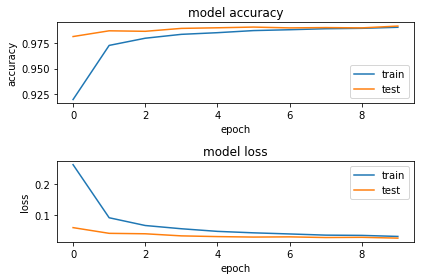

In [12]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

## Save model to disk

In [13]:
model_dir = "model"

# save model as JSON to disk
model_json = model.to_json()
with open(os.path.join(model_dir, "model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(model_dir, "model.h5"))
print("Saved model to disk")

Saved model to disk


## Load model from disk and recompile

In [14]:
# load json and create model
with open(os.path.join(model_dir, "model.json"), "r") as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
# load weights into the model
model.load_weights(os.path.join(model_dir, "model.h5"))
# recompile 
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])
print("Loaded and recompiled model")

Loaded and recompiled model


## Evaluate loaded model

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02421463741561638
Test accuracy: 0.9922
